In [1]:
import javabridge
import os
import glob
import pandas as pd
import pydot
from IPython.display import SVG

In [2]:
tetrad_libdir = os.path.join(os.getcwd(), '..','..','src', 'pycausal', 'lib')
for l in glob.glob(tetrad_libdir + os.sep + "*.jar"):
    print (l)
    javabridge.JARS.append(str(l))

/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/tetrad-lib-6.4.0-SNAPSHOT-tetradcmd.jar
/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/data-reader-0.2.3-SNAPSHOT.jar


In [3]:
javabridge.start_vm(run_headless=True, max_heap_size = '100M')
javabridge.attach()

In [4]:
data_dir = os.path.join(os.getcwd(), '..','..','data', 'charity.txt')
data_dir

'/home/jovyan/py-causal/example/javabridge/../../data/charity.txt'

In [5]:
df = pd.read_table(data_dir, sep="\t")
df.head()

,TangibilityCondition,AmountDonated,Sympathy,Imaginability,Impact
0,1.0,0.0,7.0,4.0,4.5
1,1.0,0.0,2.0,2.0,2.0
2,1.0,0.0,7.0,3.0,3.0
3,1.0,0.0,4.0,3.0,4.5
4,1.0,0.0,3.0,7.0,1.0


In [6]:
numCategoriesToDiscretize = 4
node_list = javabridge.JClassWrapper('java.util.ArrayList')()
cont_list = []
disc_list = []
col_no = 0
for col in df.columns:

    cat_array = sorted(set(df[col]))
    if(len(cat_array) > numCategoriesToDiscretize):
        # Continuous variable
        nodi = javabridge.JClassWrapper('edu.cmu.tetrad.data.ContinuousVariable')(col)
        node_list.add(nodi)

        cont_list.append(col_no)

    else:
        # Discrete variable
        cat_list = javabridge.JClassWrapper('java.util.ArrayList')()
        for cat in cat_array:
            cat = str(cat)
            cat_list.add(cat)

        nodname = javabridge.JClassWrapper('java.lang.String')(col)
        nodi = javabridge.JClassWrapper('edu.cmu.tetrad.data.DiscreteVariable')(nodname,cat_list)
        node_list.add(nodi)

        disc_list.append(col_no)

    col_no = col_no + 1

In [7]:
mixedDataBox = javabridge.JClassWrapper('edu.cmu.tetrad.data.MixedDataBox')(node_list, len(df.index))

In [8]:
for row in df.index:

    for col in cont_list:
        value = javabridge.JClassWrapper('java.lang.Double')(df.iloc[row,col])
        mixedDataBox.set(row,col,value)

    for col in disc_list:
        cat_array = sorted(set(df[df.columns[col]]))
        value = javabridge.JClassWrapper('java.lang.Integer')(cat_array.index(df.iloc[row,col]))
        mixedDataBox.set(row,col,value)

In [9]:
tetradData = javabridge.JClassWrapper('edu.cmu.tetrad.data.BoxDataSet')(mixedDataBox, node_list)

In [10]:
alpha = 0.05
discretize = False
indTest = javabridge.JClassWrapper('edu.cmu.tetrad.search.IndTestConditionalGaussianLRT')(tetradData, alpha, discretize)

In [11]:
penaltydiscount = 2 # set to 2 if variable# <= 50 otherwise set it to 4
structurePrior = 1.0
score = javabridge.JClassWrapper('edu.cmu.tetrad.search.ConditionalGaussianScore')(tetradData, structurePrior, discretize)
score.setPenaltyDiscount(penaltydiscount) 

In [12]:
gfci = javabridge.JClassWrapper('edu.cmu.tetrad.search.GFci')(indTest, score)

In [13]:
gfci.setMaxDegree(3)
gfci.setMaxPathLength(-1)
gfci.setCompleteRuleSetUsed(False)
gfci.setFaithfulnessAssumed(True)
gfci.setVerbose(True)

In [14]:
prior = javabridge.JClassWrapper('edu.cmu.tetrad.data.Knowledge2')()
prior.setForbidden('TangibilityCondition', 'Impact') # forbidden directed edges
prior.setRequired('Sympathy','TangibilityCondition') # required directed edges
prior.setTierForbiddenWithin(0, True)
prior.addToTier(0, 'TangibilityCondition')
prior.addToTier(0, 'Imaginability')
prior.addToTier(1, 'Sympathy')
prior.addToTier(1, 'AmountDonated')
prior.addToTier(2, 'Impact')
gfci.setKnowledge(prior)
prior

Instance of edu.cmu.tetrad.data.Knowledge2: /knowledge
addtemporal

0* Imaginability TangibilityCondition 
1 AmountDonated Sympathy 
2 Impact 

forbiddirect

TangibilityCondition ==> Impact 
requiredirect

Sympathy ==> TangibilityCondition 

In [15]:
tetradGraph = gfci.search()
tetradGraph

Instance of edu.cmu.tetrad.graph.EdgeListGraphSingleConnections: Graph Nodes:
TangibilityCondition,AmountDonated,Sympathy,Imaginability,Impact

Graph Edges:
1. Imaginability o-> Impact
2. Sympathy o-> Impact
3. Sympathy --> TangibilityCondition nl pd

In [16]:
tetradGraph.toString()

'Graph Nodes:\nTangibilityCondition,AmountDonated,Sympathy,Imaginability,Impact\n\nGraph Edges:\n1. Imaginability o-> Impact\n2. Sympathy o-> Impact\n3. Sympathy --> TangibilityCondition nl pd\n'

In [17]:
tetradGraph.getNodeNames()

Instance of java.util.ArrayList: [TangibilityCondition, AmountDonated, Sympathy, Imaginability, Impact]

In [18]:
tetradGraph.getEdges()

Instance of java.util.HashSet: [Sympathy o-> Impact, Sympathy --> TangibilityCondition, Imaginability o-> Impact]

In [19]:
graph = pydot.Dot(graph_type='digraph')
n = tetradGraph.getNodeNames().toString()
n = n[1:len(n)-1]
n = n.split(",")
nodes = []
for i in range(0,len(n)):
    node = n[i]
    n[i] = node.strip()
    nodes.append(pydot.Node(n[i]))
    graph.add_node(nodes[i])

In [20]:
def isNodeExisting(nodes,node):
    try:
        nodes.index(node)
        return True
    except IndexError:
        print ("Node {} does not exist!".format (node))
        return False

e = tetradGraph.getEdges().toString()
e = e[1:len(e)-1]
e = e.split(",")
for i in range(0,len(e)):
    e[i] = e[i].strip()
    token = e[i].split(" ")
    if(len(token) == 3):
        src = token[0]
        arc = token[1]
        dst = token[2]
        if(isNodeExisting(n,src) and isNodeExisting(n,dst)):
            edge = pydot.Edge(nodes[n.index(src)],nodes[n.index(dst)])
            
            if(arc[0] != "-"):
                edge.set_dir("both")
            
            if(arc[0] == "o"):
                edge.set_arrowtail("odot")
            elif(arc[0] == "<"):
                edge.set_arrowtail("normal")
            
            if(arc[2] == "-"):
                edge.set_arrowhead("none")
            elif(arc[2] == "o"):
                edge.set_arrowhead("odot")
            else:
                edge.set_arrowhead("normal")
            
            graph.add_edge(edge)

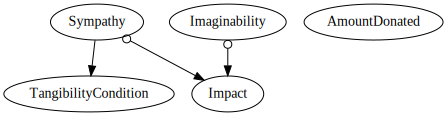

In [21]:
svg_str = graph.create_svg(prog='dot')
SVG(svg_str)

In [22]:
javabridge.detach()
javabridge.kill_vm()